In [ ]:
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from scipy.special import softmax
import multiprocessing as mp
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from torch.nn import functional as F
from sklearn.preprocessing import normalize

# Installing ProdLDA
**Restart notbook after the installation!!**

In [ ]:
!git clone https://github.com/estebandito22/PyTorchAVITM

fatal: destination path 'PyTorchAVITM' already exists and is not an empty directory.


# 1. Creation of synthetic corpus

We consider a scenario with n parties, each of them as an associated corpus.
To generate the corpus associated with each of the parties, we consider a common beta distribution (word-topic distribution), but we freeze different topics/ assign different asymmetric Dirichlet priors favoring different topics at the time of generating the document that composes each party's corpus.

## 1.1. Function for permuting the Dirichlet prior at each node

In [ ]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

## 1.2. Topic modeling and node settings

In [ ]:
# Topic modeling settings
vocab_size = 1000
n_topics = 10
beta = 1e-2
alpha = 5/n_topics
n_docs = 1000
nwords = (150, 450) #Min and max lengths of the documents

# Nodes settings
n_nodes = 5
frozen_topics = 3
dirichlet_symmetric = False
prior = (n_topics)*[0.5]
prior[0] = prior[1] = prior[2] = 0.1
print(prior)

[0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


## 1.3. Topics generation (common for all nodes)

In [ ]:
topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
print('Ordered probabilities for the first topic vector:')
print(np.sort(topic_vectors[0])[::-1])
print(topic_vectors.shape)

Ordered probabilities for the first topic vector:
[1.63604483e-001 1.28555985e-001 1.17949550e-001 7.87827092e-002
 5.38810525e-002 3.95100794e-002 3.83901077e-002 3.39982857e-002
 3.17773224e-002 2.79215339e-002 2.78305313e-002 2.22118361e-002
 2.06449417e-002 1.79311645e-002 1.44913899e-002 1.38254114e-002
 1.34284536e-002 1.23020411e-002 9.80376782e-003 9.02913802e-003
 8.97810797e-003 8.75696560e-003 7.42738077e-003 7.38114243e-003
 7.04409636e-003 6.80391179e-003 6.42993429e-003 6.37771610e-003
 5.81517050e-003 5.68817297e-003 5.54855181e-003 5.15830669e-003
 5.09643038e-003 4.61748539e-003 4.17517747e-003 3.58676750e-003
 3.11569414e-003 2.21906691e-003 2.16104175e-003 1.99500825e-003
 1.29672456e-003 1.25369920e-003 1.21100210e-003 1.18505223e-003
 1.14141320e-003 9.56652415e-004 9.36382934e-004 9.05738003e-004
 8.94615487e-004 8.26555995e-004 7.90889044e-004 7.81365522e-004
 4.78350877e-004 4.44900540e-004 3.70265593e-004 3.29306631e-004
 2.84603168e-004 1.95093053e-004 1.44862

## 1.4. Generation of document topic proportions and documents for each node


In [ ]:
doc_topics_all_gt = []
documents_all = []
z_all = []
for i in np.arange(n_nodes):
  # Step 2 - generation of document topic proportions for each node
  if dirichlet_symmetric:
    doc_topics = np.random.dirichlet((n_topics)*[alpha], n_docs)
  else:
    doc_topics = np.random.dirichlet(prior, n_docs)
    prior = rotateArray(prior, len(prior), 3)
    print(prior)
  print('Ordered probabilities for the first document - node', str(i), ':')
  print(np.sort(doc_topics[0])[::-1])
  doc_topics_all_gt.append(doc_topics)
  # Step 3 - Document generation
  documents = [] # Document words
  z = [] # Assignments
  for docid in np.arange(n_docs):
      doc_len = np.random.randint(low=nwords[0], high=nwords[1])
      this_doc_words = []
      this_doc_assigns = []
      for wd_idx in np.arange(doc_len):
          tpc = np.nonzero(np.random.multinomial(1, doc_topics[docid]))[0][0]
          this_doc_assigns.append(tpc)
          word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
          this_doc_words.append('wd'+str(word))
      z.append(this_doc_assigns)
      documents.append(this_doc_words)
  print("Documents of node", str(i), "generated.")
  documents_all.append(documents)
  z_all.append(z)

[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1]
Ordered probabilities for the first document - node 0 :
[0.20571229 0.20072752 0.19095116 0.12529139 0.10952615 0.08526831
 0.03080007 0.02737487 0.02410951 0.00023873]
Documents of node 0 generated.
[0.5, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5]
Ordered probabilities for the first document - node 1 :
[7.18153484e-01 9.65810990e-02 7.90413436e-02 4.60531346e-02
 4.57695851e-02 6.96332629e-03 3.48870404e-03 2.74470401e-03
 1.18645654e-03 1.81624802e-05]
Documents of node 1 generated.
[0.5, 0.1, 0.1, 0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Ordered probabilities for the first document - node 2 :
[6.64129215e-01 1.72829412e-01 1.00839746e-01 2.97307524e-02
 1.84086601e-02 7.45472192e-03 4.61461953e-03 1.74319590e-03
 2.32621062e-04 1.70561653e-05]
Documents of node 2 generated.
[0.1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.1, 0.1]
Ordered probabilities for the first document - node 3 :
[0.35040885 0.14670737 0.13604994 0.10887501 0.08640093 0.

# 2. Preprocessing, generation of training dataset and training of a ProdLDA model at each node

In [ ]:
ls

call_signature.png  LICENSE.md  pytorchavitm/  README.md  train_abs.py
data/               outputs/    PyTorchAVITM/  setup.py   train.py


In [ ]:
cd /content/PyTorchAVITM/pytorchavitm/datasets

/content/PyTorchAVITM/pytorchavitm/datasets


In [ ]:
from bow import BOWDataset

In [ ]:
cd /content/PyTorchAVITM

/content/PyTorchAVITM


In [ ]:
from pytorchavitm import AVITM

In [ ]:
train_datasets = []
avitms = []
id2tokens = []
for corpus_node in documents_all:
  cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
  docs = [" ".join(corpus_node[i]) for i in np.arange(len(corpus_node))]

  train_bow = cv.fit_transform(docs)
  train_bow = train_bow.toarray()

  idx2token = cv.get_feature_names()
  input_size = len(idx2token)

  id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
  id2tokens.append(id2token)

  train_data = BOWDataset(train_bow, idx2token)

  avitm = AVITM(input_size=input_size, n_components=10, model_type='prodLDA',
                hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
                learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
                solver='adam', num_epochs=100, reduce_on_plateau=False)

  avitm.fit(train_data)
  avitms.append(avitm)

  train_datasets.append(train_data)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [1000/100000]	Train Loss: 1880.1211953125	Time: 0:00:00.235274
Epoch: [2/100]	Samples: [2000/100000]	Train Loss: 1831.1458515625	Time: 0:00:00.226442
Epoch: [3/100]	Samples: [3000/100000]	Train Loss: 1799.8812265625	Time: 0:00:00.212776
Epoch: [4/100]	Samples: [4000/100000]	Train Loss: 1778.8224453125	Time: 0:00:00.212842
Epoch: [5/100]	Samples: [5000/100000]	Train Loss: 1760.7985	Time: 0:00:00.219815
Epoch: [6/100]	Samples: [6000/100000]	Train Loss: 1758.2469609375	Time: 0:00:00.198123
Epoch: [7/100]	Samples: [7000/100000]	Train Loss: 1744.1291953125	Time: 0:00:00.220910
Epoch: [8/100]	Samples: [8000/100000]	Train Loss: 1738.540453125	Time: 0:00:00.221149
Epoch: [9/100]	Samples: [9000/100000]	Train Loss: 1733.8543984375	Time: 0:00:00.202841
Epoch: [10/100]	Samples: [10000/100000]	Train Loss: 1728.93165625	Time: 0:00:00.204876
Epoch: [11/100]	Samples: [11000/100000]	Train Loss: 1723.24856640625	Time: 0:00:00.200083
Epoch: [12/100]	Samples: [12000/100000]	Train L

# 2.1 Topics at each node

In [ ]:
topics_all = []
for node in np.arange(n_nodes):
  topics = pd.DataFrame(avitm.get_topics(10)).T
  topics_all.append(topics)
topics_all[0]

,0,1,2,3,4,5,6,7,8,9
0,wd695,wd367,wd899,wd134,wd203,wd743,wd808,wd299,wd713,wd585
1,wd927,wd223,wd268,wd583,wd297,wd875,wd916,wd618,wd64,wd811
2,wd468,wd246,wd31,wd434,wd466,wd687,wd321,wd332,wd494,wd591
3,wd192,wd9,wd868,wd505,wd750,wd932,wd178,wd261,wd869,wd442
4,wd686,wd954,wd361,wd197,wd477,wd363,wd598,wd781,wd632,wd961
5,wd695,wd899,wd367,wd134,wd808,wd203,wd743,wd299,wd675,wd713
6,wd686,wd954,wd361,wd197,wd363,wd781,wd678,wd358,wd598,wd219
7,wd936,wd543,wd174,wd673,wd877,wd779,wd464,wd554,wd133,wd216
8,wd323,wd313,wd346,wd385,wd183,wd600,wd355,wd44,wd465,wd193
9,wd540,wd692,wd250,wd121,wd327,wd50,wd711,wd286,wd949,wd560


## 2.2 Document-topic distributions at each node

In [ ]:
def get_doc_topic_distribution(avitm, dataset, n_samples=20):
    avitm.model.eval()

    loader = DataLoader(
            avitm.train_data, batch_size=avitm.batch_size, shuffle=True,
            num_workers=mp.cpu_count())

    pbar = tqdm(n_samples, position=0, leave=True)

    final_thetas = []
    for sample_index in range(n_samples):
        with torch.no_grad():
            collect_theta = []

            for batch_samples in loader:
                X = batch_samples['X']

                if avitm.USE_CUDA:
                  X = X.cuda()

                # forward pass
                avitm.model.zero_grad()
                
                with torch.no_grad():
                  posterior_mu, posterior_log_sigma = avitm.model.inf_net(X)

                  # Generate samples from theta
                  theta = F.softmax(
                          avitm.model.reparameterize(posterior_mu, posterior_log_sigma), dim=1)
                  theta = avitm.model.drop_theta(theta)

                collect_theta.extend(theta.cpu().numpy().tolist())

            pbar.update(1)
            pbar.set_description("Sampling: [{}/{}]".format(sample_index + 1, n_samples))

            final_thetas.append(np.array(collect_theta))
    pbar.close()
    return np.sum(final_thetas, axis=0) / n_samples

In [ ]:
doc_topic_all = []
for node in np.arange(n_nodes):
  doc_topic = get_doc_topic_distribution(avitms[node], train_datasets[node], n_samples=5) # get all the topic predictions
  print("Document-topic distribution node", str(node), "")
  doc_topic_all.append(doc_topic)
  print(np.array(doc_topics).shape)

Sampling: [5/5]: : 5it [00:00,  5.59it/s]


Document-topic distribution node 0 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  5.57it/s]


Document-topic distribution node 1 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  5.59it/s]


Document-topic distribution node 2 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  5.89it/s]


Document-topic distribution node 3 
(1000, 10)


Sampling: [5/5]: : 5it [00:00,  5.67it/s]

Document-topic distribution node 4 
(1000, 10)


## 2.3 Word-topic distributions attained at each node

In [ ]:
def get_topic_word_distribution(avtim_model):
  topic_word_matrix = avtim_model.model.beta.cpu().detach().numpy()
  return softmax(topic_word_matrix, axis=1)

In [ ]:
all_words = []
for word in np.arange(vocab_size+1):
  if word > 0:
    all_words.append('wd'+str(word))
print(all_words)

['wd1', 'wd2', 'wd3', 'wd4', 'wd5', 'wd6', 'wd7', 'wd8', 'wd9', 'wd10', 'wd11', 'wd12', 'wd13', 'wd14', 'wd15', 'wd16', 'wd17', 'wd18', 'wd19', 'wd20', 'wd21', 'wd22', 'wd23', 'wd24', 'wd25', 'wd26', 'wd27', 'wd28', 'wd29', 'wd30', 'wd31', 'wd32', 'wd33', 'wd34', 'wd35', 'wd36', 'wd37', 'wd38', 'wd39', 'wd40', 'wd41', 'wd42', 'wd43', 'wd44', 'wd45', 'wd46', 'wd47', 'wd48', 'wd49', 'wd50', 'wd51', 'wd52', 'wd53', 'wd54', 'wd55', 'wd56', 'wd57', 'wd58', 'wd59', 'wd60', 'wd61', 'wd62', 'wd63', 'wd64', 'wd65', 'wd66', 'wd67', 'wd68', 'wd69', 'wd70', 'wd71', 'wd72', 'wd73', 'wd74', 'wd75', 'wd76', 'wd77', 'wd78', 'wd79', 'wd80', 'wd81', 'wd82', 'wd83', 'wd84', 'wd85', 'wd86', 'wd87', 'wd88', 'wd89', 'wd90', 'wd91', 'wd92', 'wd93', 'wd94', 'wd95', 'wd96', 'wd97', 'wd98', 'wd99', 'wd100', 'wd101', 'wd102', 'wd103', 'wd104', 'wd105', 'wd106', 'wd107', 'wd108', 'wd109', 'wd110', 'wd111', 'wd112', 'wd113', 'wd114', 'wd115', 'wd116', 'wd117', 'wd118', 'wd119', 'wd120', 'wd121', 'wd122', 'wd123', 

In [ ]:
topic_word_all = []
for node in np.arange(n_nodes):
  w_t_distrib = np.zeros((10,vocab_size), dtype=np.float64) 
  wd = get_topic_word_distribution(avitms[node])
  for i in np.arange(10):
    for idx, word in id2tokens[node].items():
      for j in np.arange(len(all_words)):
        if all_words[j] == word:
          w_t_distrib[i,j] = wd[i][idx]
          break
  sum_of_rows = w_t_distrib.sum(axis=1)
  normalized_array = w_t_distrib / sum_of_rows[:, np.newaxis]
  topic_word_all.append(normalized_array)

# 3. Centralized model

In [ ]:
documents_centr = [*documents_all[0], *documents_all[1], *documents_all[2], *documents_all[3], *documents_all[4]]
len(documents_centr)

5000

In [ ]:
cv = CountVectorizer(input='content', lowercase=True, stop_words='english',
                      max_df=0.99, min_df=0.01, binary=False)
  
docs_centr = [" ".join(documents_centr[i]) for i in np.arange(len(documents_centr))]

train_bow_centr = cv.fit_transform(docs_centr)
train_bow_centr = train_bow_centr.toarray()

idx2token_centr = cv.get_feature_names()
input_size_centr = len(idx2token_centr)

id2token_centr = {k: v for k, v in zip(range(0, len(idx2token_centr)), idx2token_centr)}

train_data_centr = BOWDataset(train_bow_centr, idx2token_centr)

avitm_centr = AVITM(input_size=input_size_centr, n_components=10, model_type='prodLDA',
              hidden_sizes=(100, 100), activation='softplus', dropout=0.2,
              learn_priors=True, batch_size=64, lr=2e-3, momentum=0.99,
              solver='adam', num_epochs=100, reduce_on_plateau=False)

avitm_centr.fit(train_data_centr)

Settings: 
               N Components: 10
               Topic Prior Mean: 0.0
               Topic Prior Variance: 0.9
               Model Type: prodLDA
               Hidden Sizes: (100, 100)
               Activation: softplus
               Dropout: 0.2
               Learn Priors: True
               Learning Rate: 0.002
               Momentum: 0.99
               Reduce On Plateau: False
               Save Dir: None


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Epoch: [1/100]	Samples: [5000/500000]	Train Loss: 1845.97925390625	Time: 0:00:00.592948
Epoch: [2/100]	Samples: [10000/500000]	Train Loss: 1770.353270703125	Time: 0:00:00.566519
Epoch: [3/100]	Samples: [15000/500000]	Train Loss: 1747.76899140625	Time: 0:00:00.593393
Epoch: [4/100]	Samples: [20000/500000]	Train Loss: 1733.783206640625	Time: 0:00:00.551633
Epoch: [5/100]	Samples: [25000/500000]	Train Loss: 1725.75482890625	Time: 0:00:00.539926
Epoch: [6/100]	Samples: [30000/500000]	Train Loss: 1718.508185546875	Time: 0:00:00.555262
Epoch: [7/100]	Samples: [35000/500000]	Train Loss: 1710.2378388671875	Time: 0:00:00.574936
Epoch: [8/100]	Samples: [40000/500000]	Train Loss: 1704.9462158203125	Time: 0:00:00.539135
Epoch: [9/100]	Samples: [45000/500000]	Train Loss: 1695.9770697265626	Time: 0:00:00.554984
Epoch: [10/100]	Samples: [50000/500000]	Train Loss: 1696.4189505859374	Time: 0:00:00.599552
Epoch: [11/100]	Samples: [55000/500000]	Train Loss: 1694.6548703125	Time: 0:00:00.558937
Epoch: [12

In [ ]:
topics_centr = pd.DataFrame(avitm_centr.get_topics(10)).T
topics_centr

,0,1,2,3,4,5,6,7,8,9
0,wd299,wd695,wd899,wd367,wd203,wd848,wd743,wd365,wd808,wd57
1,wd192,wd9,wd932,wd178,wd505,wd295,wd102,wd407,wd868,wd750
2,wd151,wd45,wd742,wd755,wd503,wd510,wd569,wd946,wd102,wd506
3,wd949,wd235,wd540,wd692,wd286,wd121,wd250,wd711,wd914,wd520
4,wd936,wd543,wd673,wd779,wd174,wd877,wd554,wd464,wd414,wd840
5,wd183,wd346,wd313,wd600,wd385,wd44,wd193,wd140,wd703,wd960
6,wd75,wd235,wd931,wd957,wd228,wd698,wd844,wd651,wd74,wd477
7,wd59,wd583,wd223,wd927,wd64,wd916,wd811,wd297,wd618,wd840
8,wd687,wd466,wd988,wd31,wd277,wd734,wd468,wd494,wd72,wd434
9,wd563,wd595,wd886,wd196,wd428,wd747,wd273,wd857,wd97,wd298


In [ ]:
doc_topic_centr = get_doc_topic_distribution(avitm_centr, train_data_centr, n_samples=5) # get all the topic predictions
print(doc_topic_centr.shape)

Sampling: [5/5]: : 5it [00:01,  2.63it/s]

(5000, 10)


In [ ]:
w_t_distrib_centr = np.zeros((10,vocab_size), dtype=np.float64) # vocab_size = 10000
wd = get_topic_word_distribution(avitm_centr)
for i in np.arange(10):
  for idx, word in id2token_centr.items():
    for j in np.arange(len(all_words)):
      if all_words[j] == word:
        w_t_distrib_centr[i,j] = wd[i][idx]
        break
sum_of_rows = w_t_distrib_centr.sum(axis=1)
w_t_distrib_centr_norm = w_t_distrib_centr / sum_of_rows[:, np.newaxis]
print(w_t_distrib_centr_norm)
sum(w_t_distrib_centr_norm[8,:])

[[0.         0.         0.         ... 0.00231558 0.         0.        ]
 [0.         0.         0.         ... 0.00226759 0.         0.        ]
 [0.         0.         0.         ... 0.00228929 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00232625 0.         0.        ]
 [0.         0.         0.         ... 0.00230814 0.         0.        ]
 [0.         0.         0.         ... 0.00229191 0.         0.        ]]


0.9999999999999993

# 4. Get similarity through Frobenius

In [ ]:
doc_topic_centr_all = []
doc_topic_centr_all.append(doc_topic_centr[0:1000,:])
doc_topic_centr_all.append(doc_topic_centr[1000:2000,:])
doc_topic_centr_all.append(doc_topic_centr[2000:3000,:])
doc_topic_centr_all.append(doc_topic_centr[3000:4000,:])
doc_topic_centr_all.append(doc_topic_centr[4000:5000,:])

In [ ]:
for node in np.arange(n_nodes):
  # Ground truth in node vs inferred in node
  doc_topics_avitm_sqrt_node = np.sqrt(doc_topic_all[node])
  similarity_avitm_node = doc_topics_avitm_sqrt_node.dot(doc_topics_avitm_sqrt_node.T)

  doc_topics_gt_sqrt_node = np.sqrt(doc_topics_all_gt[node])
  similarity_gt = doc_topics_gt_sqrt_node.dot(doc_topics_gt_sqrt_node.T)

  diff_sims = similarity_avitm_node - similarity_gt
  frobenius_diff_sims_node = np.linalg.norm(diff_sims,'fro')

  # Ground truth in node vs centralized (for documents of such a node)
  doc_topics_avitm_sqrt_centr_node = np.sqrt(doc_topic_centr_all[node])
  similarity_avitm_centr = doc_topics_avitm_sqrt_centr_node.dot(doc_topics_avitm_sqrt_centr_node.T)

  diff_sims = similarity_avitm_centr - similarity_gt
  frobenius_diff_sims_avg = np.linalg.norm(diff_sims,'fro')

  print("NODE", str(node))
  print("GT vs inferred in node:", frobenius_diff_sims_node)
  print("GT vs centralized in node", frobenius_diff_sims_avg)
  print("***************************************************************")

NODE 0
GT vs inferred in node: 287.22899328830357
GT vs centralized in node 282.6274262262078
***************************************************************
NODE 1
GT vs inferred in node: 286.912069724552
GT vs centralized in node 285.37066121923334
***************************************************************
NODE 2
GT vs inferred in node: 284.24708007151776
GT vs centralized in node 284.44226885643246
***************************************************************
NODE 3
GT vs inferred in node: 287.79330734013394
GT vs centralized in node 284.4844914002617
***************************************************************
NODE 4
GT vs inferred in node: 291.5531050392916
GT vs centralized in node 291.4189817720329
***************************************************************


In [ ]:
for node in np.arange(n_nodes):
  # GT vs inferred in node
  topic_words_gt_sqrt = np.sqrt(topic_vectors)
  topic_words_avtim_node_sqrt = np.sqrt(topic_word_all[node])
  simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_node_sqrt.T)

  simmat_t_w_pd = pd.DataFrame(simmat_t_w)
  maxValues_rows = simmat_t_w_pd.max(axis = 1)
  max_values_rows_sum = maxValues_rows.sum()

  print("NODE", str(node))
  print("Original vs inferred in node sum max row:", max_values_rows_sum)
  print("***************************************************************")

# GT vs centralized
topic_words_avtim_centr_sqrt = np.sqrt(w_t_distrib_centr_norm)
simmat_t_w = topic_words_gt_sqrt.dot(topic_words_avtim_centr_sqrt.T)

simmat_t_w_pd = pd.DataFrame(simmat_t_w)
maxValues_rows = simmat_t_w_pd.max(axis = 1)
max_values_rows_sum_centr = maxValues_rows.sum()

print("CENTRALIZED")
print("Original vs avg of inferred in nodes sum max row", max_values_rows_sum_centr)

NODE 0
Original vs inferred in node sum max row: 1.0923508780294666
***************************************************************
NODE 1
Original vs inferred in node sum max row: 1.1560196602730293
***************************************************************
NODE 2
Original vs inferred in node sum max row: 1.1830830689462692
***************************************************************
NODE 3
Original vs inferred in node sum max row: 1.0744695974009768
***************************************************************
NODE 4
Original vs inferred in node sum max row: 1.1517160148190082
***************************************************************
CENTRALIZED
Original vs avg of inferred in nodes sum max row 1.1576834722534899


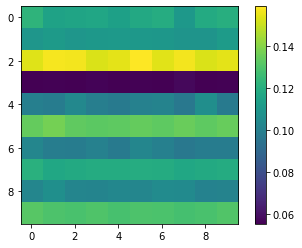

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(simmat_t_w)
plt.colorbar()
plt.show()